In [71]:
import math
import os
import numpy as np
from scipy.odr import *
import matplotlib.pyplot as plt
#from operator import itemgetter

In [72]:
class Espectro:
    def __init__(self):
        self.muestra = None
        self.cuentas = []
        self.canales = []
        self.velocidades = []
        self.energias = []

In [73]:
espectros = {}
carpeta = "datos/1ra_parte/"

for filename in os.listdir(carpeta):
    temp_spec = Espectro()
    temp_spec.muestra = filename.split(".")[0]  # me quedo con el nombre de la muestra

    temp_file = open(carpeta+filename)                              
    temp_spec.cuentas = [float(x) for x in temp_file.readlines()]   # tomo el valor en notación
    temp_spec.cuentas = [int(x) for x in temp_spec.cuentas]         # científica y lo paso a
    temp_spec.canales = [ch for ch in range(len(temp_spec.cuentas))]# formato entero

    if temp_spec.muestra in list(espectros):
        espectros[temp_spec.muestra].append(temp_spec)
    else:
        espectros[temp_spec.muestra] = []
        espectros[temp_spec.muestra].append(temp_spec)

#chequeo que esté todo bien definido
#print(list(espectros))
#for elem in espectros.keys():
#    for i in range(len(espectros[elem])):
#        print(espectros[elem][i].muestra,len(espectros[elem][i].canales),len(espectros[elem][i].cuentas),len(espectros[elem][i].energias))

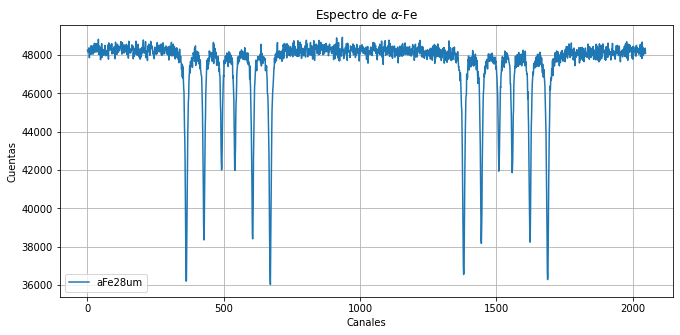

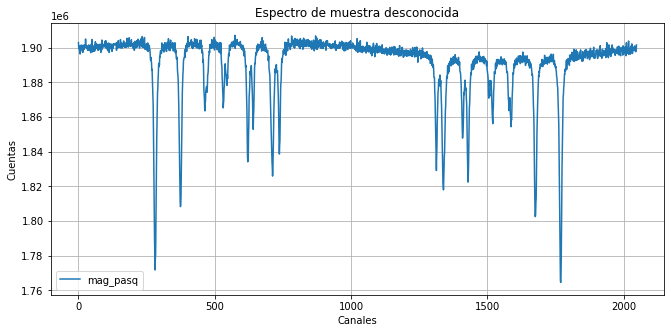

In [74]:
# gráficos   

sample_names = {"aFe28um":r"$\alpha$-Fe", "mag_pasq":"muestra desconocida"}

for key in espectros.keys():
    
    fig = plt.figure(figsize=(11,5))
    
    for spec in espectros[key]:
        plt.plot(spec.cuentas, label='{}'.format(key))
    
    plt.title("Espectro de {}".format(sample_names[key]))
    #plt.xlim(0,1024)
    plt.xlabel("Canales")
    plt.ylabel("Cuentas")
    plt.legend()
    plt.grid()
    plt.show()

In [75]:
def split_spec(spec,final_lenght,shift):
    # función para dividir el espectro en dos

    # mitad izquierda
    izq_min = shift
    izq_max = shift + final_lenght
    izq = [x for x in spec[izq_min:izq_max]]

    # mitad derecha
    der_min = shift + final_lenght + 1
    der_max = shift + 2*final_lenght
    der = [x for x in spec[der_min:der_max+1]]

    return izq,der

def mirror_compatibility(spec,max_shift):
    # acá es donde sucede la magia

    chi2 = []
    init_lenght = len(spec)                             # 2048
    final_lenght = int((init_lenght - max_shift)/2)     # 1014, el tamaño de la mitad de 
                                                        # la ventana usada
    old_chi2 = float("inf")
    for shift in range(max_shift):  # shift in [0,...,20] posición de la ventana respecto 
        temp_chi2 = 0               # al primer canal original

        izq,der = split_spec(spec,final_lenght,shift)

        # calculo las sumas cuadráticas
        for ch in range(final_lenght):
            temp_chi2 += (izq[ch] - der[final_lenght-1-ch])**2
        temp_chi2 /= final_lenght   # divido por la cantidad de canales por si quiero 
        chi2.append(temp_chi2)      # comparar con distintos tamaños de ventana (?) ahre

        # me voy quedando con el que da el mínimo
        if temp_chi2 < old_chi2:
            ok_shift = shift
        old_chi2 = temp_chi2
        
    return ok_shift, final_lenght, chi2

Corrimiento:  11


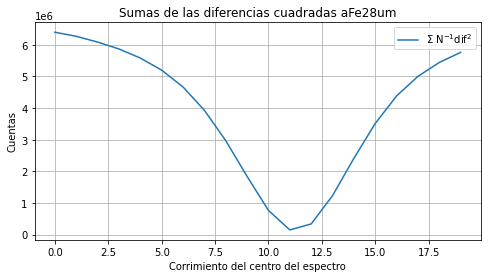

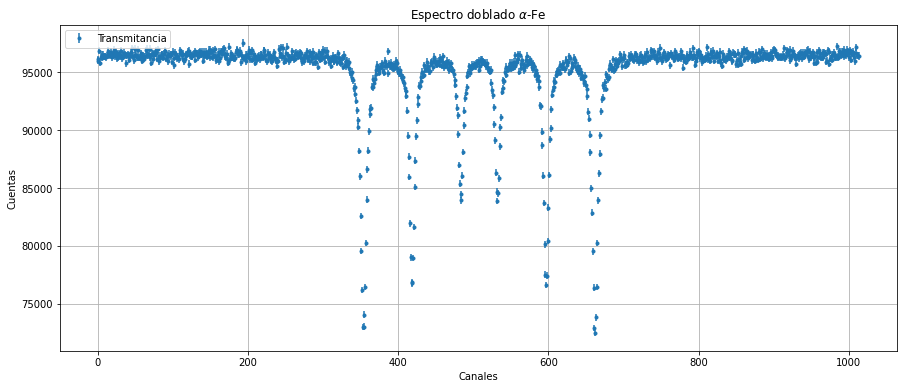

Corrimiento:  11


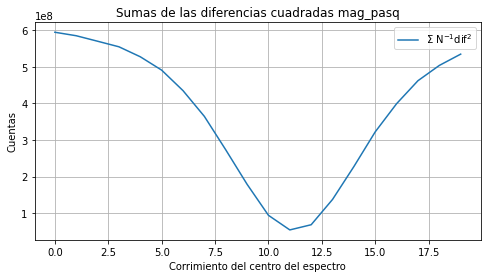

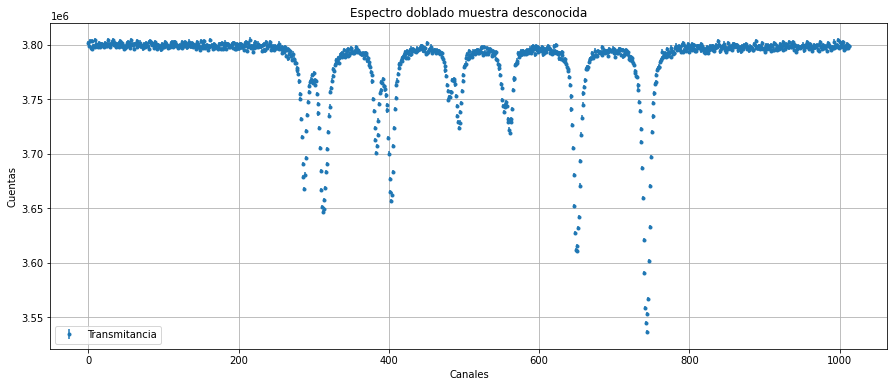

In [76]:
# busco el canal en donde doblar el espectro: armo una ventana móvil y divido el espectro en dos, después me quedo con la posición de la ventana que de la menor suma de ((izq_i - der_i)**2)/N
# también grafico las sumas en función del corrimiento de la ventana
# también obtengo el espectro final: doblado y sumado

max_shift = 20  # es también la cantidad de canales que se descartan al seleccionar la 
                # ventana. mejor si es par porque la cantidad inicial de canales es par :B

for key in espectros.keys():
    for spec in espectros[key]:
        # busco el corrimiento adecuado para el centro del espectro
        ok_shift, final_lenght, chi2 = mirror_compatibility(spec.cuentas,max_shift)
        print("Corrimiento: ", ok_shift)    # es importante que el corrimiento sea el mismo
                                            # para todos los espectros para poder hacer la 
                                            # calibración en velocidades
        # the chosen one
        izq,der = split_spec(spec.cuentas,final_lenght,ok_shift)
        izq.reverse()   # doblo el izq sobre el der, el segundo es magnetita xd
        spec.cuentas = [x + y for x, y in zip(izq, der)]
        spec.canales = list(range(final_lenght))
        # CUIDADO: acá se sobreescribió el espectro para poder usarlo así directamente. 
        # NO correr esta celda nuevamente antes de resetear los valores de las variables
        # del notebook.

        # grafico las sumas para cada corrimiento
        fig = plt.figure(figsize=(8,4))
        plt.plot(chi2, label=r"$\Sigma$ N$^{-1}$dif$^2$")
        #chi2_min_index = min(enumerate(chi2), key=itemgetter(1))[0] # el shift adecuado
        plt.title("Sumas de las diferencias cuadradas {}".format(key))
        plt.legend()
        plt.xlabel("Corrimiento del centro del espectro")
        plt.ylabel("Cuentas")
        plt.grid()
        plt.show()

        # grafico los espectros finales
        err_cuentas = [np.sqrt(0.25 + np.abs(x)) for x in spec.cuentas]

        fig = plt.figure(figsize=(15,6))
        plt.errorbar(spec.canales, spec.cuentas, yerr=err_cuentas, label=r"Transmitancia", fmt='.')
        plt.title("Espectro doblado {}".format(sample_names[key]))
        plt.legend()
        plt.xlabel("Canales")
        plt.ylabel("Cuentas")
        plt.grid()
        plt.show()

In [77]:
# funciones a ajustar

# lorentziana para un solo pico
def lorentz(A,E):
    return A[2]*A[1]/(2*np.pi)/((E-A[0])**2+(A[1]/2)**2)

# lorentziana para un solo pico con línea de base
def lorentz_bl(A,E):
    return A[2]*A[1]/(2*np.pi)/((E-A[0])**2+(A[1]/2)**2) + A[3]

# suma de n lorentzianas
def sum_lor_n(A,E,n):
    sumita = lambda E:[lorentz([A[3*i],A[3*i+1],A[3*i+2]],E) for i in range(n)]
    return sum(sumita(E)) + A[3*n]

def dos_sextetes(A,E,area_rates):
    # 27 parámetros en A: 2x[6x[centroide, ancho] + área] + baseline
    sumita = lambda E:[lorentz([A[2*i],area_rates[i]*A[2*6],A[2*i+1]],E) for i in range(6)]
    sumita2 = lambda E:[lorentz([A[2*i+13],area_rates[i]*A[2*6+13],A[2*i+14]],E) for i in range(6)]
    return sum(sumita(E)) + sum(sumita2(E)) + A[2*6+14]


In [78]:
def search_mins_alFe(canales,cuentas,threshold):
    # función que busca los picos

    ch_min = 0
    count_min = 0
    peak_counter = 0
    old_peak_counter = 0

    ch_mins = []
    count_mins = []

    for ch in canales:
        if cuentas[ch] < count_min:
            ch_min = ch
            old_peak_counter = peak_counter
        else:
            if cuentas[ch] < threshold and peak_counter == old_peak_counter:
                ch_mins.append(ch_min)
                count_mins.append(count_min)
                peak_counter += 1
        
        count_min = cuentas[ch]

    return ch_mins, count_mins, peak_counter

In [79]:
def ajustin_castor(muestra,func,n,baseline,beta0,canal,err_canal,cuentas,err_cuentas):
    # función que hace el ajuste
    # baseline: línea de base. se asume fondo constante.

    #defino el modelo y los datos
    alFe_model = Model(func, extra_args=[n])
    data = RealData(canal, cuentas, sx = err_canal, sy = err_cuentas)

    # hago el ajuste y me quedo con los parámetros, sus errores y la varianza residual
    odr_fit = ODR(data, alFe_model, beta0=beta0)
    odr_fit_output = odr_fit.run()
    fit_params = odr_fit_output.beta
    err_fit_params = odr_fit_output.sd_beta
    chi2_red = odr_fit_output.res_var

    print("params: ", '\n', fit_params,'\n')
    print("err_params: ", '\n', err_fit_params,'\n')
    print("chi2_red: ", chi2_red,'\n')

    return fit_params, err_fit_params, chi2_red

In [80]:
def h_plotter(muestra,func,n,fit_params,err_fit_params,xlim,canal,err_canal,cuentas,err_cuentas):
    # función que grafica xd
    
    fig = plt.figure(figsize=(15,6))
    plt.errorbar(canal, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
    plt.plot(canal, func(fit_params,canal,n), label='Ajuste lorentz')
    plt.xlabel("Canales")
    plt.ylabel("Cuentas")
    plt.title("Ajuste para {}".format(sample_names[muestra]))
    plt.xlim(xlim)
    plt.grid()
    plt.legend()
    plt.show()

ch_mins:      [353, 418, 483, 532, 597, 662]
count_mins:  [24041.0, 20245.0, 13076.0, 13132.0, 20374.0, 24517.0]
peaks:  6 

parametros iniciales(19):  [353, 5, -48082.0, 418, 5, -40490.0, 483, 5, -26152.0, 532, 5, -26264.0, 597, 5, -40748.0, 662, 5, -49034.0, 97000.0] 

params:  
 [ 3.53870259e+02  8.49495859e+00 -3.18516167e+05  4.18620605e+02
  7.72647986e+00 -2.40737629e+05  4.83279014e+02  7.14678702e+00
 -1.39420176e+05  5.32163821e+02  7.14708986e+00 -1.40885243e+05
  5.97019921e+02  7.54008533e+00 -2.34314137e+05  6.61904265e+02
  8.61349114e+00 -3.24418192e+05  9.64510359e+04] 

err_params:  
 [1.07839006e-01 1.74514880e-01 5.24030342e+03 1.16322037e-01
 1.84671766e-01 4.69673814e+03 1.34091761e-01 2.28478475e-01
 3.68720700e+03 1.34591474e-01 2.28278183e-01 3.72062269e+03
 1.19093665e-01 1.60474733e-01 4.50445842e+03 1.09560922e-01
 1.45404664e-01 4.94858179e+03 1.15988073e+01] 

chi2_red:  0.962186939980133 



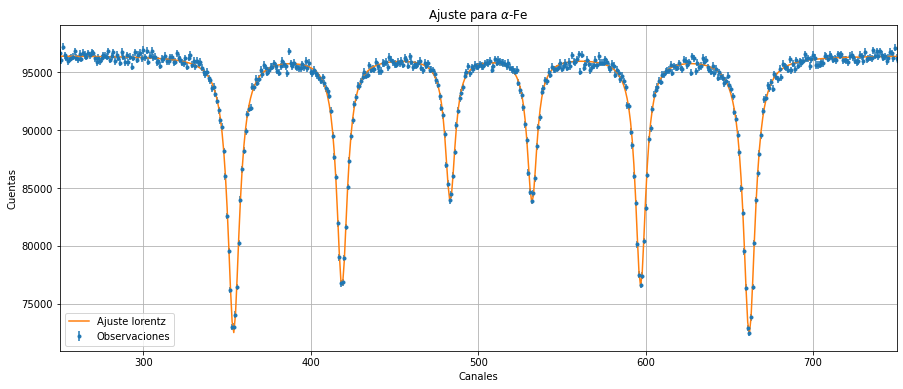

In [81]:
# el ajuste para el alfa-Fe de calibración

# tomo los datos
muestra = "aFe28um"
canal = espectros[muestra][0].canales
err_canal = 0.5
cuentas = espectros[muestra][0].cuentas
err_cuentas = [np.sqrt(0.25 + np.abs(x)) for x in cuentas]  # apreciación**2 + poisson**2

# busco los picos
threshold = 8.5e4
baseline = 9.7e4
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
count_mins = [baseline-x for x in count_mins]
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
beta0 = [j for i in ch_mins for j in [i,5,-2*(baseline-cuentas[i])]]
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)), beta0,'\n')

# hago el ajuste
func = sum_lor_n
n = peak_counter
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, n, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico
h_plotter(muestra,func,n,fit_params,err_fit_params,[250,750],canal,err_canal,cuentas,err_cuentas)

In [82]:
# recta de calibración
def recta_calib(A,x):
    return A[0] + A[1]*np.array(x)

params:  [-17.67261119   0.03445643] 

err_params:  [7.31127676e-03 1.41251607e-05] 

chi2_red:  0.8349966195999085 



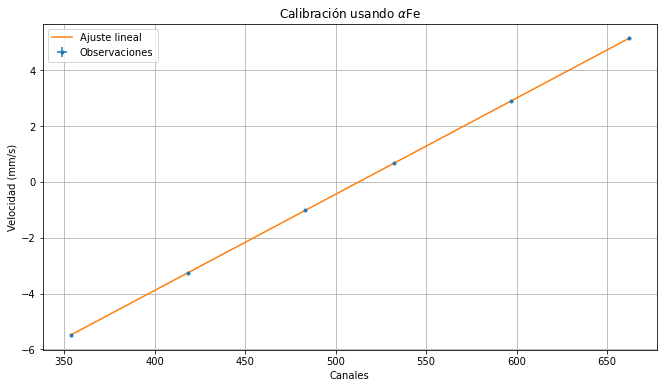

In [83]:
# calibración en velocidad (mm/s)

# valores obtenidos en "Mössbauer Line Positions and Hyperfine Interactions in α Iron" C. E. Violet and D. N. Pipkorn para alfa-Fe utilizando una fuente de 57Co-Pd ambos a 298K
line_pos = [-5.4823, -3.2473, -1.0132, 0.6624, 2.8967, 5.1338]  # en mm/s
err_line_pos = [8e-4, 8e-4, 10e-4, 7e-4, 7e-4, 10e-4]

# centroides de los picos ajustados
centroides = [fit_params[3*i] for i in range(6)]
err_centroides = [err_fit_params[3*i] for i in range(6)]

# defino el modelo y los datos
linear_model = Model(recta_calib)
data = RealData(centroides, line_pos, sx=err_centroides, sy=err_line_pos)

# ajusto
odr_lin_fit = ODR(data, linear_model, beta0=[-16,2.24/64.8])
odr_lin_fit_output = odr_lin_fit.run()

# extraigo los parámetros de interés
lin_fit_params = odr_lin_fit_output.beta
err_lin_fit_params = odr_lin_fit_output.sd_beta
lin_chi2_red = odr_lin_fit_output.res_var
print("params: ", lin_fit_params,'\n')
print("err_params: ", err_lin_fit_params,'\n')
print("chi2_red: ", lin_chi2_red,'\n')

# grafico
fig = plt.figure(figsize=(11,6))
plt.errorbar(centroides, line_pos, xerr=err_centroides, yerr=err_line_pos, fmt ='.', label='Observaciones')
plt.plot(centroides, recta_calib(lin_fit_params,centroides), label='Ajuste lineal')
plt.xlabel("Canales")
plt.ylabel("Velocidad (mm/s)")
plt.title(r"Calibración usando $\alpha$Fe")
plt.grid()
plt.legend()
plt.show()

In [84]:
# cálculo de las velocidades en mm/s en base a la calibración con alfa-Fe
for key in espectros:
    for spec in espectros[key]:
        spec.velocidades = [recta_calib(lin_fit_params,x) for x in spec.canales]

In [85]:
def h_plotter_v(muestra,func,n,fit_params,err_fit_params,xlim,canal,err_canal,cuentas,err_cuentas):
    # función que grafica pero en velocidades xd
    vels = recta_calib(lin_fit_params,canal)

    fig = plt.figure(figsize=(15,6))
    plt.errorbar(vels, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
    plt.plot(vels, func(fit_params,canal,n), label='Ajuste lorentz')
    plt.xlabel("Velocidad (mm/s)")
    plt.ylabel("Cuentas")
    plt.title("Ajuste para {}".format(sample_names[muestra]))
    plt.xlim(xlim)
    plt.grid()
    plt.legend()
    plt.show()

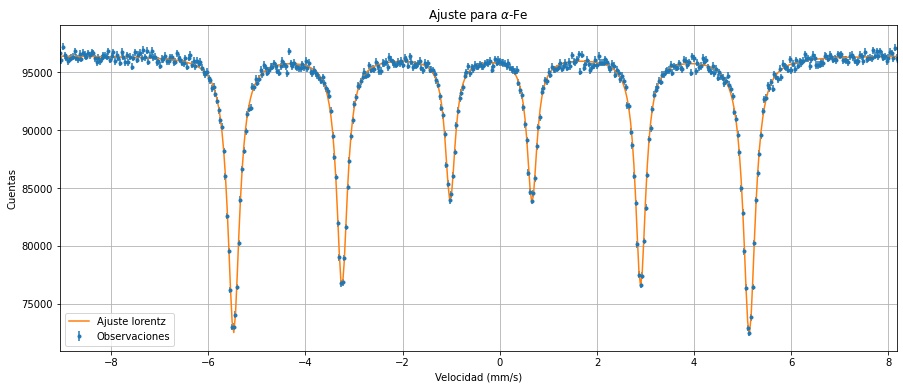

In [86]:
# grafico el espectro del alfa-Fe pero en velocidades
h_plotter_v(muestra,func,n,fit_params,err_fit_params,recta_calib(lin_fit_params,[250,750]),canal,err_canal,cuentas,err_cuentas)

In [87]:
# funciones para calcular los parámetros hiperfinos

# error de las velocidades luego de la calibración
def err_calib(cent,errcent):
    v = np.array(cent)
    errv = np.array(errcent)
    return np.sqrt((lin_fit_params[1]*errv)**2 + (v*err_lin_fit_params[1])**2 + (err_lin_fit_params[0])**2)

# corrimiento isomérico
def iso_val(v):
    return 0.25*(v[0]+v[5]) + 0.125*(v[1]+v[2]+v[3]+v[4])

# desdoblamiento cuadrupolar eléctrico
def eq_val(v):
    return 0.25*(v[0]+v[5]) - 0.125*(v[1]+v[2]+v[3]+v[4])

# error iso y eq porque son iguales
def err_isoeq_val(errv):
    return np.sqrt((0.25**2)*(errv[0]**2+errv[5]**2) + (0.125**2)*(errv[1]**2+errv[2]**2+errv[3]**2+errv[4]**2))

# promedio pesado
def w_mean(nvals,vals,errvals):
    w_tot = 0
    for i in range(nvals):
        w_tot += 1/errvals[i]**2
    
    mean = 0
    for i in range(nvals):
        mean += vals[i]/(errvals[i]**2)
    mean /= w_tot

    return mean, 1/np.sqrt(w_tot)

# distancia internivel del efecto zeeman para J = 1/2
def Delta0_val(v,errv):
    val1 = v[4] - v[2]
    val2 = v[3] - v[1]

    errval1 = np.sqrt(errv[4]**2 + errv[2]**2)
    errval2 = np.sqrt(errv[3]**2 + errv[1]**2)
    
    #print("deltas0:",val1,val2)
    return w_mean(2,[val1,val2],[errval1,errval2])

# distancia internivel del efecto zeeman para J = 3/2
def Delta1_val(v,errv):
    val1 = v[2] - v[1]
    val2 = v[4] - v[3]
    val3 = 0.5*(v[1] - v[0] + v[5] - v[4])

    errval1 = np.sqrt(errv[2]**2 + errv[1]**2)
    errval2 = np.sqrt(errv[4]**2 + errv[3]**2)
    errval3 = 0.5*np.sqrt(errv[1]**2 + errv[0]**2 + errv[5]**2 + errv[4]**2)

    #print("deltas1:",val1,val2,val3)
    return w_mean(3,[val1,val2,val3],[errval1,errval2,errval3])

# funciones para el campo magnético hiperfino medido en T
mm_s = 4.80799e-8   # 1 mm/s equivale a 4.80799e-8 eV para la fuente de alfa-Fe
muN = 3.15245125844e-8  # magnetón nuclear en eV/T, lo considero constante
                        # por su error: (96) en los últimos dos dígitos
mu0, errmu0 = w_mean(3,[0.09044,0.090623,0.0907638],[7e-5,9e-8,1e-7])
mu1, errmu1 = 0.1549, 2e-4
print("mues: ",muN,mu0,errmu0,mu1,errmu1)

g0 = mu0/(1/2)    # factor de Landé nuclear del Fe para J = 1/2
errg0 = errmu0/(1/2)
g1 = mu1/(3/2)     # factor de Landé nuclear del Fe para J = 3/2
errg1 = errmu1/(3/2)

def B_value(delta0,delta1):
    # transformo a eV
    delta0_ev = delta0*mm_s
    delta1_ev = delta1*mm_s

    #print("Bhfs",delta0_ev/g0/muN,delta1_ev/g1/muN)
    return (delta0_ev/g0 + delta1_ev/g1)/(2*muN)

def err_B_value(delta0,errdelta0,delta1,errdelta1):
    # transformo a eV
    delta0_ev = delta0*mm_s
    errdelta0_ev = errdelta0*mm_s
    delta1_ev = delta1*mm_s
    errdelta1_ev = errdelta1*mm_s

    return np.sqrt((errdelta0_ev/g0)**2 + (errdelta1_ev/g1)**2 + (delta0_ev*errg0/(g0**2))**2 + (delta1_ev*errg1/(g1**2))**2)/(2*muN)

mues:  3.15245125844e-08 0.09068600972007229 6.689644261420902e-08 0.1549 0.0002


In [88]:
# chequeo si hay acuerdo con los valores reportados por violet. spoiler: sí hay

# transformo los centroides a mm/s
centroides_v = recta_calib(lin_fit_params,centroides)
err_centroides_v = err_calib(centroides,err_centroides)

# parámetros de nuestra muestra
iso = iso_val(centroides_v)
iso_alFe = iso
err_iso = err_isoeq_val(err_centroides_v)
err_iso_alFe = err_iso

eq =  eq_val(centroides_v)
err_eq = err_isoeq_val(err_centroides_v)

Delta0, err_Delta0 = Delta0_val(centroides_v,err_centroides_v)

Delta1, err_Delta1 = Delta1_val(centroides_v,err_centroides_v)

Bhf = B_value(Delta0,Delta1)
err_Bhf = err_B_value(Delta0,err_Delta0,Delta1,err_Delta1)

# recalculo los parámetros de referencia para verificar que estén bien las cuentas
iso_ref = iso_val(line_pos)
err_iso_ref = err_isoeq_val(err_line_pos)

eq_ref = eq_val(line_pos)
err_eq_ref = err_isoeq_val(err_line_pos)

Delta0_ref, err_Delta0_ref = Delta0_val(line_pos,err_line_pos)

Delta1_ref, err_Delta1_ref = Delta1_val(line_pos,err_line_pos)

Bhf_ref = B_value(Delta0_ref,Delta1_ref)
err_Bhf_ref = err_B_value(Delta0_ref,err_Delta0_ref,Delta1_ref,err_Delta1_ref)

# imprimo
print("todo en mm/s salvo que se aclare lo contrario")
print("los valores de referencia no son los reportados si no los recalculados a partir de las líneas reportadas; salvo que se aclare lo contrario",'\n')
print("centroides ref:",line_pos)
print("err centroides ref:",err_line_pos,'\n')

print("centroides:",centroides_v)
print("err centroides:",err_centroides_v,'\n')

print("center shift ref:",iso_ref,"+/-",err_iso_ref)
print("center shift:",'\t',iso,"+/-",err_iso)
print("Cuad. Elec. ref:",4*eq_ref,"+/-",4*err_eq_ref)
print("Cuad. Elec.:",'\t',4*eq,"+/-",err_eq,'\n')

print("Delta0 ref:",'\t',Delta0_ref,"+/-",err_Delta0_ref)
print("Delta0:",'\t',Delta0,"+/-",err_Delta0)
print("Delta1 ref:",'\t',Delta1_ref,"+/-",err_Delta1_ref)
print("Delta1:",'\t',Delta1,"+/-",err_Delta1,'\n')
print("Bhf ref reportado: -330.4(3) kOe")
print("Bhf citado por Long: 33 T")
print("Bhf ref:",'\t',Bhf_ref,"+/-",err_Bhf_ref,"T")
print("Bhf:",'\t','\t',Bhf,"+/-",err_Bhf,"T")

todo en mm/s salvo que se aclare lo contrario
los valores de referencia no son los reportados si no los recalculados a partir de las líneas reportadas; salvo que se aclare lo contrario 

centroides ref: [-5.4823, -3.2473, -1.0132, 0.6624, 2.8967, 5.1338]
err centroides ref: [0.0008, 0.0008, 0.001, 0.0007, 0.0007, 0.001] 

centroides: [-5.4795047  -3.24843881 -1.02054074  0.66385529  2.8985651   5.13424808]
err centroides: [0.00960449 0.01022173 0.01101825 0.01146583 0.01189157 0.01245469] 

center shift ref: -0.17480000000000018 +/- 0.0003787314351885779
center shift: 	 -0.1746340495935219 +/- 0.0048221854588490825
Cuad. Elec. ref: 0.0021999999999997577 +/- 0.0015149257407543117
Cuad. Elec.: 	 0.008022949934941792 +/- 0.0048221854588490825 

Delta0 ref: 	 3.9097862595419848 +/- 0.0008016443025346463
Delta0: 	 3.915516536954321 +/- 0.011150263476409825
Delta1 ref: 	 2.235082355949789 +/- 0.0005703394405914062
Delta1: 	 2.232180053120955 +/- 0.007856489007684075 

Bhf ref reportado: -330

In [89]:
def mag_hidden_peaks(ch_mins,param,peaks):
    # agrega los picos escondidos de la magnetita. tiene dos tipos de sitios intersticiales ocupados por isómeros distintos: 1 catión Fe(III) en todos los sitios tetrahédricos (A) y en la mitad de los sitios octahédricos (B) y 1 catión Fe(II) en la otra mitad. Además hay el doble de sitios B que de A. Fórmula estructural (Fe(III))_tet[Fe(II)Fe(III)]_octO4. Tomado de Gütlich P., Ensling J., "Handbook of Analytical Technics" (2001), sec. 19.7.1, p. 574.
    
    # 10 picos
    if peaks == 10:
        if param == "ch":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9], ch_mins[10]]
    
        if param == "count":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9], ch_mins[10]]
    
    # 11 picos versión 1
    if peaks == 11:
        if param == "ch":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9], ch_mins[9], ch_mins[10]]
    
        if param == "count":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9]/3, 2*ch_mins[9]/3, ch_mins[10]]

    # 11 picos versión 2
    if peaks == 11.5:
        if param == "ch":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9], ch_mins[10], ch_mins[10]+1]
    
        if param == "count":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9], 2*ch_mins[10]/3, ch_mins[10]/3]

    # 2 sextetes
    if peaks == 12:
        if param == "ch":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9], ch_mins[9], ch_mins[10], ch_mins[10]]
    
        if param == "count":
            return [ch_mins[0], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[9]/3, 2*ch_mins[9]/3, 2*ch_mins[10]/3, ch_mins[10]/3]
    
    # 3 sextetes
    if peaks == 18:
        if param == "ch":
            return [ch_mins[0], ch_mins[1], ch_mins[1], ch_mins[2], ch_mins[3], ch_mins[3], ch_mins[4], ch_mins[5], ch_mins[5], ch_mins[6], ch_mins[8], ch_mins[8], ch_mins[9], ch_mins[9], ch_mins[9], ch_mins[10], ch_mins[10], ch_mins[10]]
    
        if param == "count":
            return [ch_mins[0], ch_mins[1]/2, ch_mins[1]/2, ch_mins[2], ch_mins[3]/2, ch_mins[3]/2, ch_mins[4], ch_mins[5]/2, ch_mins[5]/2, ch_mins[6], ch_mins[8]/2, ch_mins[8]/2, ch_mins[9]/3, ch_mins[9]/3, ch_mins[9]/3, ch_mins[10]/3, ch_mins[10]/3, ch_mins[10]/3]

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 555, 561, 650, 743]
count_mins:  [3667741, 3646645, 3700729, 3656573, 3749114, 3723805, 3738514, 3742573, 3719013, 3610870, 3536342]
peaks:  11 

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 561, 650, 743]
count_mins:  [132259.0, 153355.0, 99271.0, 143427.0, 50886.0, 76195.0, 61486.0, 80987.0, 189130.0, 263658.0]
peaks:  10 

parametros iniciales(31):  
 [287, 5, -264518.0, 312, 5, -306710.0, 383, 5, -198542.0, 403, 5, -286854.0, 479, 5, -101772.0, 493, 5, -152390.0, 553, 5, -122972.0, 561, 5, -161974.0, 650, 5, -378260.0, 743, 5, -527316.0, 3800000.0] 

params:  
 [ 2.86756221e+02  7.31494079e+00 -1.44007785e+06  3.12977841e+02
  1.05390097e+01 -2.55463736e+06  3.83202119e+02  7.26343337e+00
 -1.04184528e+06  4.02808165e+02  8.32339315e+00 -1.81991598e+06
  4.79686030e+02  7.63888569e+00 -5.10195918e+05  4.93047320e+02
  8.47844249e+00 -9.41276623e+05  5.52436451e+02  7.72402850e+00
 -5.46053196e+05  5.60983080e+02  7.93104154e+00

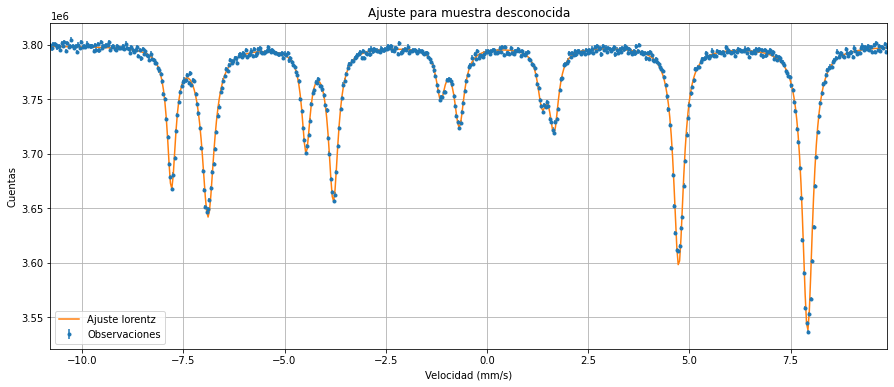

In [90]:
# el ajuste para la muestra desconocida (magnetita) sólo con 10 lorentzianas

# tomo los datos
muestra = "mag_pasq"
canal = espectros[muestra][0].canales
err_canal = 0.5
cuentas = espectros[muestra][0].cuentas
err_cuentas = [np.sqrt(0.25 + np.abs(x)) for x in cuentas]  # apreciación**2 + poisson**2

# busco los picos
threshold = 3.76e6
baseline = 3.8e6
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# agrego los picos escondidos
ch_mins = mag_hidden_peaks(ch_mins,"ch",10)
count_mins = [baseline-x for x in count_mins]
count_mins = mag_hidden_peaks(count_mins,"count",10)
peak_counter = len(ch_mins)

print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
beta0 = [j for i in ch_mins for j in [i,5,-2*(baseline-cuentas[i])]]
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)),'\n', beta0,'\n')

# hago el ajuste
func = sum_lor_n
n = peak_counter
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, n, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico pero en velocidades
h_plotter_v(muestra,func,n,fit_params,err_fit_params,recta_calib(lin_fit_params,[200,800]),canal,err_canal,cuentas,err_cuentas)

10


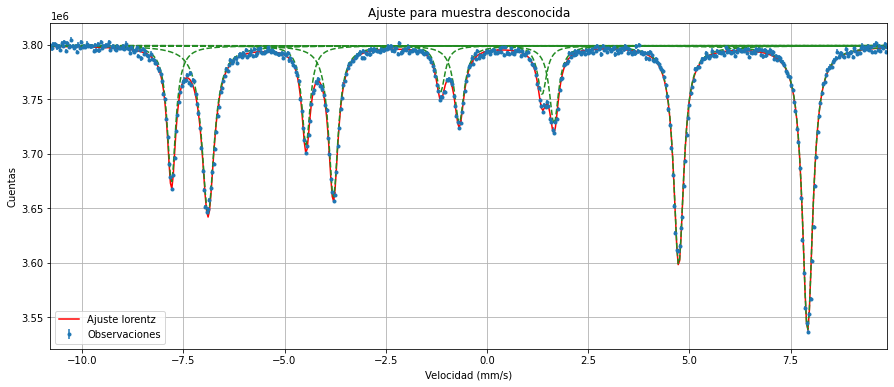

In [91]:
# grafico con las curvas diferenciadas para cada lorentziana
print(n)
vels = recta_calib(lin_fit_params,canal)

fig = plt.figure(figsize=(15,6))
plt.errorbar(vels, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
plt.plot(vels, func(fit_params,canal,n), color='red',label='Ajuste lorentz')
for i in range(n):
    plt.plot(vels, lorentz([fit_params[3*i],fit_params[3*i+1],fit_params[3*i+2]],canal)+fit_params[3*n], color='forestgreen', linestyle='--')

plt.xlabel("Velocidad (mm/s)")
plt.ylabel("Cuentas")
plt.title("Ajuste para {}".format(sample_names[muestra]))
plt.xlim(recta_calib(lin_fit_params,[200,800]))
plt.grid()
plt.legend()
plt.show()

In [92]:
def hf_param(cent_v,err_cent_v):
    # función que calcula los parámetros hiperfinos a partir de un sextete

    # corrimiento del centro
    iso = iso_val(cent_v)
    err_iso = err_isoeq_val(err_cent_v)

    # interacción cuadrupolar eléctrica
    eq =  eq_val(cent_v)
    err_eq = err_isoeq_val(err_cent_v)

    # efecto zeeman nuclear
    Delta0, err_Delta0 = Delta0_val(cent_v,err_cent_v)
    Delta1, err_Delta1 = Delta1_val(cent_v,err_cent_v)

    mu1_mu0 = 3*Delta1/Delta0
    err_mu1_mu0 = mu1_mu0*np.sqrt((err_Delta0/Delta0)**2 + (err_Delta1/Delta1)**2)

    Bhf = B_value(Delta0,Delta1)
    err_Bhf = err_B_value(Delta0,err_Delta0,Delta1,err_Delta1)

    # imprimo
    print("center shift:",'\t',iso,"+/-",err_iso)
    print("Cuad. Elec.:",'\t',eq,"+/-",err_eq)
    print("mu1/mu0:",'\t',mu1_mu0,"+/-",err_mu1_mu0)
    print("Bhf:",'\t','\t',Bhf,"+/-",err_Bhf,"T",'\n')

    return iso,err_iso,eq,err_eq,Bhf,err_Bhf

In [93]:
# PARÁMETROS HIPERFINOS con 10 lorentzianas

# me quedó sólo con las posiciones de los centroides
cent_A = [fit_params[0],fit_params[6],fit_params[12],fit_params[18],fit_params[24],fit_params[27]]
err_cent_A = [err_fit_params[0],err_fit_params[6],err_fit_params[12],err_fit_params[18],err_fit_params[24],err_fit_params[27]]
cent_B = [fit_params[3],fit_params[9],fit_params[15],fit_params[21],fit_params[24],fit_params[27]]
err_cent_B = [err_fit_params[3],err_fit_params[9],err_fit_params[15],err_fit_params[21],err_fit_params[24],err_fit_params[27]]

# transformo los centroides a mm/s
cent_A = recta_calib(lin_fit_params,cent_A)
err_cent_A = err_calib(centroides,err_cent_A)

cent_B = recta_calib(lin_fit_params,cent_B)
err_cent_B = err_calib(centroides,err_cent_B)

# les quito el corrimiento del alfa-Fe
cent_A = [i - iso_alFe for i in cent_A]
err_cent_A = [np.sqrt(i**2 + err_iso_alFe**2) for i in err_cent_A]

cent_B = [i - iso_alFe for i in cent_B]
err_cent_B = [np.sqrt(i**2 + err_iso_alFe**2) for i in err_cent_B]

# imprimo
print("todo en mm/s salvo que se aclare lo contrario",'\n')

print("---------------------------- sitio A ----------------------------",'\n')
print("centroides A:",cent_A)
print("err centroides A:",err_cent_A,'\n')

iso_A, err_iso_A, eq_A, err_eq_A, Bhf_A, err_Bhf_A = hf_param(cent_A,err_cent_A)

print("Ref Silva(2012)")
print("center shift: 0.19(1111)")
print("Cuad. Elec.: -0.02(1111)")
print("Bhf: 49.22(1111) T",'\n')

print("Ref cositasFe")
print("center shift: 0.15(1111)")
print("Cuad. Elec.: -0.02(1111)")
print("Bhf: 49.20(1111) T",'\n')

print("Ref Handbook of analytical techniques")
print("Bhf: 49(1111) T",'\n')

print("---------------------------- sitio B ----------------------------",'\n')
print("centroides B:",cent_B)
print("err centroides B:",err_cent_B,'\n')

iso_B, err_iso_B, eq_B, err_eq_B, Bhf_B, err_Bhf_B = hf_param(cent_B,err_cent_B)

print("Ref Silva(2012)")
print("center shift: 0.54(1111)")
print("Cuad. Elec.: -0.00(1111)")
print("Bhf: 45.78(1111) T",'\n')

print("Ref cositasFe")
print("center shift: 0.56(1111)")
print("Cuad. Elec.: 0.00(1111)")
print("Bhf: 46.00(1111) T",'\n')

print("Ref Handbook of analytical techniques")
print("Bhf: 49(1111) T",'\n')

todo en mm/s salvo que se aclare lo contrario 

---------------------------- sitio A ---------------------------- 

centroides A: [-7.617380928661106, -4.294199405643468, -0.9697080931368123, 1.5370118632577463, 4.91007397888945, 8.094474381184241]
err centroides A: [0.011120615713172315, 0.011720522185892654, 0.013016451066359161, 0.014087444612885622, 0.01278375729906449, 0.013347891105222229] 

center shift: 	 0.2671706560516483 +/- 0.005414125547270901
Cuad. Elec.: 	 -0.028623929790080604 +/- 0.005414125547270901
mu1/mu0: 	 1.6896765520760735 +/- 0.0058865668809813705
Bhf: 	 	 48.9744132422089 +/- 0.09083634452599891 T 

Ref Silva(2012)
center shift: 0.19(1111)
Cuad. Elec.: -0.02(1111)
Bhf: 49.22(1111) T 

Ref cositasFe
center shift: 0.15(1111)
Cuad. Elec.: -0.02(1111)
Bhf: 49.20(1111) T 

Ref Handbook of analytical techniques
Bhf: 49(1111) T 

---------------------------- sitio B ---------------------------- 

centroides B: [-6.71387746897288, -3.618645022350687, -0.50932569594384

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 555, 561, 650, 743]
count_mins:  [3667741, 3646645, 3700729, 3656573, 3749114, 3723805, 3738514, 3742573, 3719013, 3610870, 3536342]
peaks:  11 

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 561, 650, 650, 743]
count_mins:  [132259.0, 153355.0, 99271.0, 143427.0, 50886.0, 76195.0, 61486.0, 80987.0, 63043.333333333336, 126086.66666666667, 263658.0]
peaks:  11 

parametros iniciales(34):  
 [287, 5, -264518.0, 312, 5, -306710.0, 383, 5, -198542.0, 403, 5, -286854.0, 479, 5, -101772.0, 493, 5, -152390.0, 553, 5, -122972.0, 561, 5, -161974.0, 650, 5, -378260.0, 650, 5, -378260.0, 743, 5, -527316.0, 3800000.0] 

params:  
 [ 2.86757876e+02  7.32209359e+00 -1.44061718e+06  3.12984434e+02
  1.06891168e+01 -2.53317001e+06  3.83203823e+02  7.26863318e+00
 -1.04228356e+06  4.02814820e+02  8.42761229e+00 -1.80737564e+06
  4.79737092e+02  7.79859768e+00 -5.14283409e+05  4.93062161e+02
  8.44727944e+00 -9.34986406e+05  5.52513433e+02  8.2303237

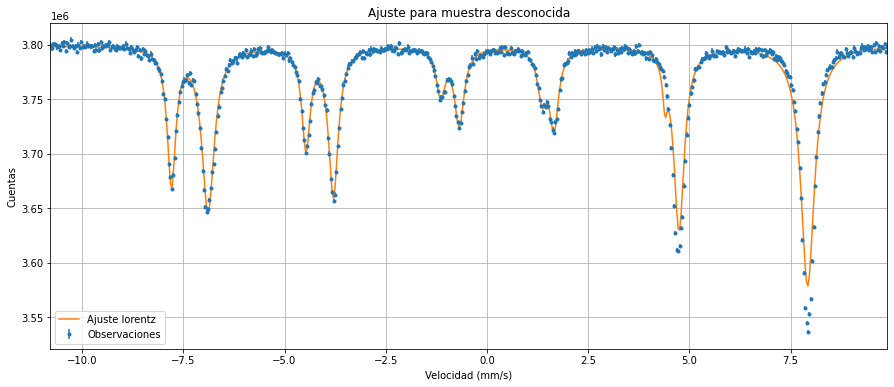

In [94]:
# el ajuste para la muestra desconocida (magnetita) sólo con 11 lorentzianas versión 1

# busco los picos
threshold = 3.76e6
baseline = 3.8e6
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# agrego los picos escondidos
ch_mins = mag_hidden_peaks(ch_mins,"ch",11)
count_mins = [baseline-x for x in count_mins]
count_mins = mag_hidden_peaks(count_mins,"count",11)
peak_counter = len(ch_mins)

print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
beta0 = [j for i in ch_mins for j in [i,5,-2*(baseline-cuentas[i])]]
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)),'\n', beta0,'\n')

# hago el ajuste
func = sum_lor_n
n = peak_counter
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, n, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico pero en velocidades
h_plotter_v(muestra,func,n,fit_params,err_fit_params,recta_calib(lin_fit_params,[200,800]),canal,err_canal,cuentas,err_cuentas)

11


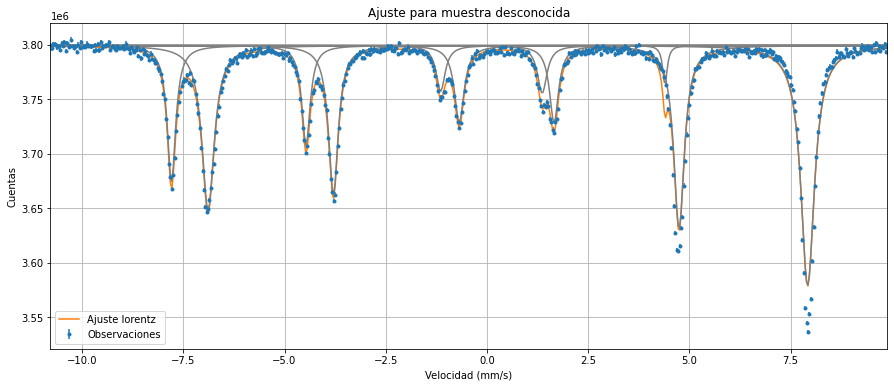

In [95]:
# grafico con las curvas diferenciadas para cada lorenztiana
print(n)
vels = recta_calib(lin_fit_params,canal)

fig = plt.figure(figsize=(15,6))
plt.errorbar(vels, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
plt.plot(vels, func(fit_params,canal,n), label='Ajuste lorentz')
for i in range(n):
    plt.plot(vels, lorentz([fit_params[3*i],fit_params[3*i+1],fit_params[3*i+2]],canal)+fit_params[3*n], color='gray')

plt.xlabel("Velocidad (mm/s)")
plt.ylabel("Cuentas")
plt.title("Ajuste para {}".format(sample_names[muestra]))
plt.xlim(recta_calib(lin_fit_params,[200,800]))
plt.grid()
plt.legend()
plt.show()

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 555, 561, 650, 743]
count_mins:  [3667741, 3646645, 3700729, 3656573, 3749114, 3723805, 3738514, 3742573, 3719013, 3610870, 3536342]
peaks:  11 

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 561, 650, 743, 744]
count_mins:  [132259.0, 153355.0, 99271.0, 143427.0, 50886.0, 76195.0, 61486.0, 80987.0, 189130.0, 175772.0, 87886.0]
peaks:  11 

parametros iniciales(34):  
 [287, 5, -264518.0, 312, 5, -306710.0, 383, 5, -198542.0, 403, 5, -286854.0, 479, 5, -101772.0, 493, 5, -152390.0, 553, 5, -122972.0, 561, 5, -161974.0, 650, 5, -378260.0, 743, 5, -527316.0, 744, 5, -494054.0, 3800000.0] 

params:  
 [ 2.87317519e+02  6.91168934e+00 -1.00606179e+06  3.12821265e+02
  1.36260888e+01 -1.63135385e+06  3.83960560e+02  5.85005185e+00
 -6.69801273e+05  4.02307944e+02  8.38053001e+00 -1.20897834e+06
  4.80490651e+02  4.65058596e+00 -2.46211405e+05  4.92623933e+02
  5.43322765e+00 -4.83526294e+05  5.53178469e+02  4.94920685e+00
 -3.17811747e+0

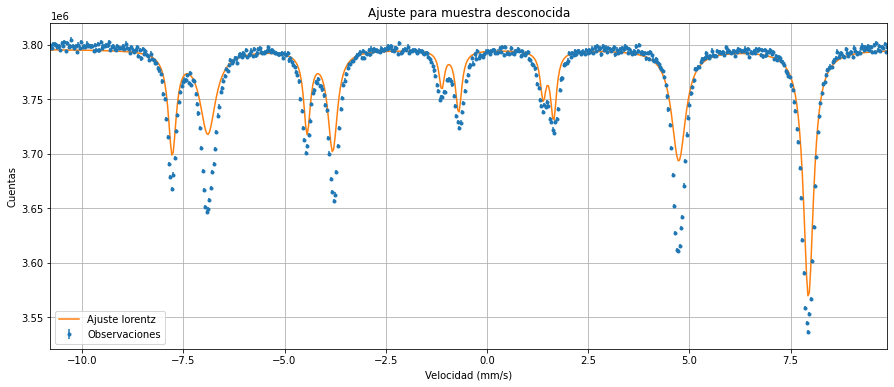

In [96]:
# el ajuste para la muestra desconocida (magnetita) sólo con 11 lorentzianas versión 2

# busco los picos
threshold = 3.76e6
baseline = 3.8e6
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# agrego los picos escondidos
ch_mins = mag_hidden_peaks(ch_mins,"ch",11.5)
count_mins = [baseline-x for x in count_mins]
count_mins = mag_hidden_peaks(count_mins,"count",11.5)
peak_counter = len(ch_mins)

print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
beta0 = [j for i in ch_mins for j in [i,5,-2*(baseline-cuentas[i])]]
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)),'\n', beta0,'\n')

# hago el ajuste
func = sum_lor_n
n = peak_counter
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, n, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico pero en velocidades
h_plotter_v(muestra,func,n,fit_params,err_fit_params,recta_calib(lin_fit_params,[200,800]),canal,err_canal,cuentas,err_cuentas)

11


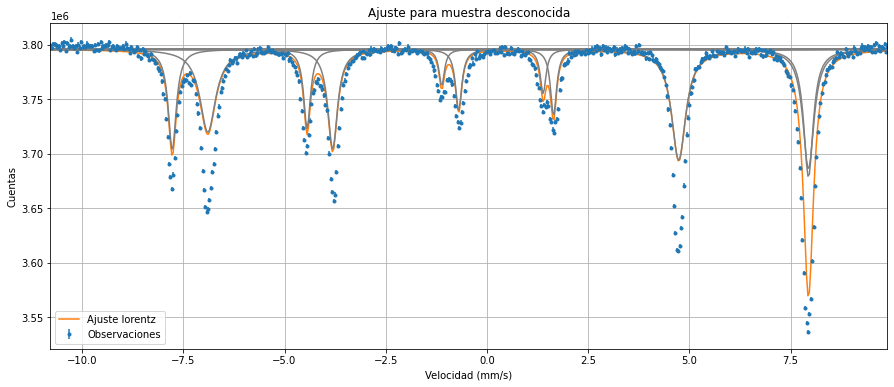

In [97]:
# grafico con las curvas diferenciadas para cada lorenztiana
print(n)
vels = recta_calib(lin_fit_params,canal)

fig = plt.figure(figsize=(15,6))
plt.errorbar(vels, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
plt.plot(vels, func(fit_params,canal,n), label='Ajuste lorentz')
for i in range(n):
    plt.plot(vels, lorentz([fit_params[3*i],fit_params[3*i+1],fit_params[3*i+2]],canal)+fit_params[3*n], color='gray')

plt.xlabel("Velocidad (mm/s)")
plt.ylabel("Cuentas")
plt.title("Ajuste para {}".format(sample_names[muestra]))
plt.xlim(recta_calib(lin_fit_params,[200,800]))
plt.grid()
plt.legend()
plt.show()

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 555, 561, 650, 743]
count_mins:  [3667741, 3646645, 3700729, 3656573, 3749114, 3723805, 3738514, 3742573, 3719013, 3610870, 3536342]
peaks:  11 

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 561, 650, 650, 743, 743]
count_mins:  [132259.0, 153355.0, 99271.0, 143427.0, 50886.0, 76195.0, 61486.0, 80987.0, 63043.333333333336, 126086.66666666667, 175772.0, 87886.0]
peaks:  12 

parametros iniciales(37):  
 [287, 5, -264518.0, 312, 5, -306710.0, 383, 5, -198542.0, 403, 5, -286854.0, 479, 5, -101772.0, 493, 5, -152390.0, 553, 5, -122972.0, 561, 5, -161974.0, 650, 5, -378260.0, 650, 5, -378260.0, 743, 5, -527316.0, 743, 5, -527316.0, 3800000.0] 

params:  
 [ 2.86760526e+02  7.30175500e+00 -1.43506015e+06  3.12975905e+02
  1.06144940e+01 -2.53758264e+06  3.83213435e+02  7.26004507e+00
 -1.04090505e+06  4.02811112e+02  8.35646415e+00 -1.80246989e+06
  4.79696483e+02  7.68228956e+00 -5.10759889e+05  4.93049170e+02
  8.44709080e+00 -9.374992

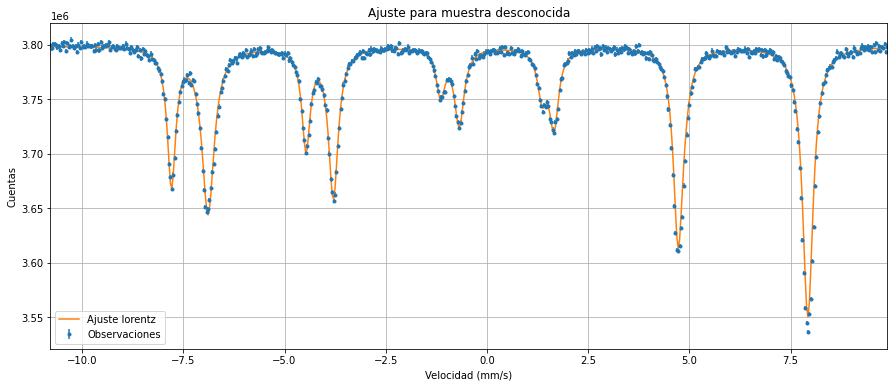

In [98]:
# el ajuste para la muestra desconocida (magnetita) con 12 lorentzianas

# busco los picos
threshold = 3.76e6
baseline = 3.8e6
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# agrego los picos escondidos
ch_mins = mag_hidden_peaks(ch_mins,"ch",12)
count_mins = [baseline-x for x in count_mins]
count_mins = mag_hidden_peaks(count_mins,"count",12)
peak_counter = len(ch_mins)

print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
beta0 = [j for i in ch_mins for j in [i,5,-2*(baseline-cuentas[i])]]
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)),'\n', beta0,'\n')

# hago el ajuste
func = sum_lor_n
n = peak_counter
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, n, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico pero en velocidades
h_plotter_v(muestra,func,n,fit_params,err_fit_params,recta_calib(lin_fit_params,[200,800]),canal,err_canal,cuentas,err_cuentas)

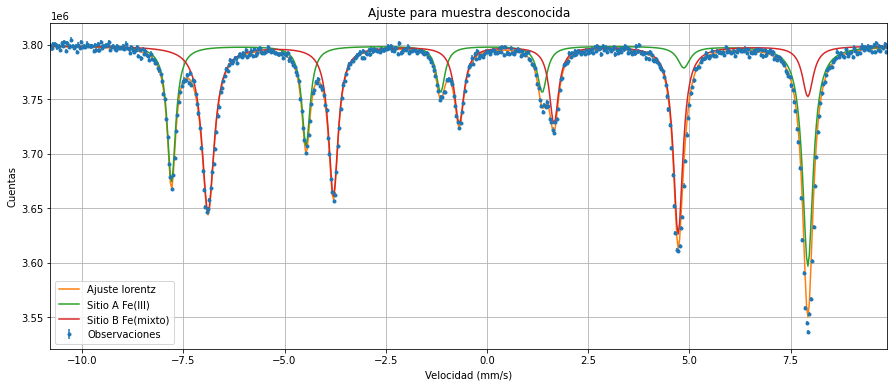

In [99]:
# grafico con las curvas diferenciadas para cada sextete

params_A = [fit_params[3*2*i+j] for i in range(6) for j in range(3)]
params_A.append(fit_params[36])

params_B = [fit_params[3*(2*i+1)+j] for i in range(6) for j in range(3)]
params_B.append(fit_params[36])

vels = recta_calib(lin_fit_params,canal)

#grafico
fig = plt.figure(figsize=(15,6))
plt.errorbar(vels, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
plt.plot(vels, func(fit_params,canal,n), label='Ajuste lorentz')
plt.plot(vels, func(params_A,canal,6), label='Sitio A Fe(III)')
plt.plot(vels, func(params_B,canal,6), label='Sitio B Fe(mixto)')

plt.xlabel("Velocidad (mm/s)")
plt.ylabel("Cuentas")
plt.title("Ajuste para {}".format(sample_names[muestra]))
plt.xlim(recta_calib(lin_fit_params,[200,800]))
plt.grid()
plt.legend()
plt.show()

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 555, 561, 650, 743]
count_mins:  [3667741, 3646645, 3700729, 3656573, 3749114, 3723805, 3738514, 3742573, 3719013, 3610870, 3536342]
peaks:  11 

ch_mins:      [287, 312, 312, 383, 403, 403, 479, 493, 493, 553, 561, 561, 650, 650, 650, 743, 743, 743]
count_mins:  [132259.0, 76677.5, 76677.5, 99271.0, 71713.5, 71713.5, 50886.0, 38097.5, 38097.5, 61486.0, 40493.5, 40493.5, 63043.333333333336, 63043.333333333336, 63043.333333333336, 87886.0, 87886.0, 87886.0]
peaks:  18 

parametros iniciales(55):  
 [287, 7, -264518.0, 312, 7, -306710.0, 312, 7, -306710.0, 383, 7, -198542.0, 403, 7, -286854.0, 403, 7, -286854.0, 479, 7, -101772.0, 493, 7, -152390.0, 493, 7, -152390.0, 553, 7, -122972.0, 561, 7, -161974.0, 561, 7, -161974.0, 650, 7, -378260.0, 650, 7, -378260.0, 650, 7, -378260.0, 743, 7, -527316.0, 743, 7, -527316.0, 743, 7, -527316.0, 3800000.0] 

params:  
 [ 2.86678470e+02  7.65761851e+00 -1.49511061e+06  3.16672103e+02
  9.43508888e+0

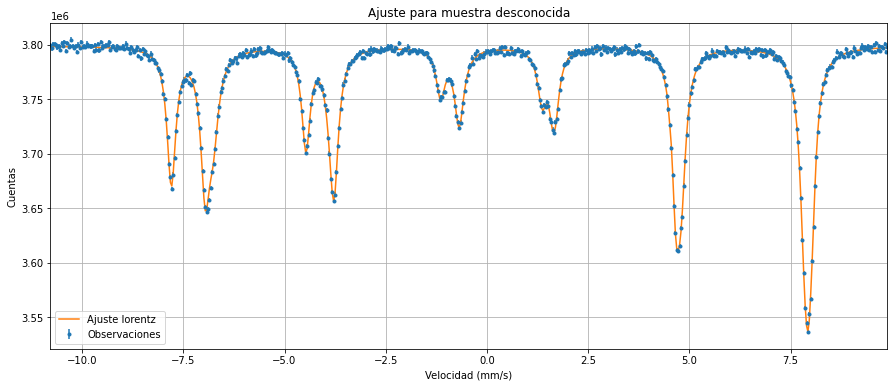

In [100]:
# el ajuste para la muestra desconocida (magnetita) con 18 lorentzianas

# busco los picos
threshold = 3.76e6
baseline = 3.8e6
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# agrego los picos escondidos
ch_mins = mag_hidden_peaks(ch_mins,"ch",18)
count_mins = [baseline-x for x in count_mins]
count_mins = mag_hidden_peaks(count_mins,"count",18)
peak_counter = len(ch_mins)

print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
beta0 = [j for i in ch_mins for j in [i,7,-2*(baseline-cuentas[i])]]
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)),'\n', beta0,'\n')

# hago el ajuste
func = sum_lor_n
n = peak_counter
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, n, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico pero en velocidades
h_plotter_v(muestra,func,n,fit_params,err_fit_params,recta_calib(lin_fit_params,[200,800]),canal,err_canal,cuentas,err_cuentas)

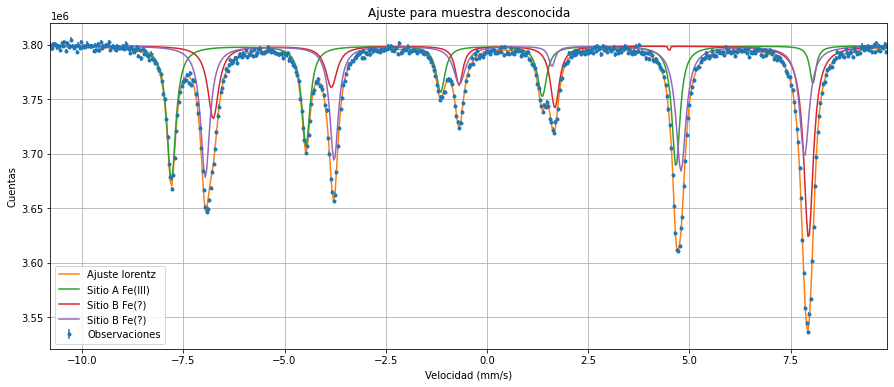

In [101]:
params_A = [fit_params[3*3*i+j] for i in range(6) for j in range(3)]
params_A.append(fit_params[54])

params_B_izq = [fit_params[3*(3*i+1)+j] for i in range(6) for j in range(3)]
params_B_izq.append(fit_params[54])

params_B_der = [fit_params[3*(3*i+2)+j] for i in range(6) for j in range(3)]
params_B_der.append(fit_params[54])

vels = recta_calib(lin_fit_params,canal)

#grafico
fig = plt.figure(figsize=(15,6))
plt.errorbar(vels, cuentas, yerr = err_cuentas, fmt ='.', label='Observaciones')
plt.plot(vels, func(fit_params,canal,n), label='Ajuste lorentz')
plt.plot(vels, func(params_A,canal,6), label='Sitio A Fe(III)')
plt.plot(vels, func(params_B_izq,canal,6), label='Sitio B Fe(?)')
plt.plot(vels, func(params_B_der,canal,6), label='Sitio B Fe(?)')

plt.xlabel("Velocidad (mm/s)")
plt.ylabel("Cuentas")
plt.title("Ajuste para {}".format(sample_names[muestra]))
plt.xlim(recta_calib(lin_fit_params,[200,800]))
plt.grid()
plt.legend()
plt.show()

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 555, 561, 650, 743]
count_mins:  [3667741, 3646645, 3700729, 3656573, 3749114, 3723805, 3738514, 3742573, 3719013, 3610870, 3536342]
peaks:  11 

ch_mins:      [287, 312, 383, 403, 479, 493, 553, 561, 650, 650, 743, 743]
count_mins:  [132259.0, 153355.0, 99271.0, 143427.0, 50886.0, 76195.0, 61486.0, 80987.0, 63043.333333333336, 126086.66666666667, 175772.0, 87886.0]
peaks:  12 

parametros iniciales(27):  
 [287, 5, 383, 5, 479, 5, 553, 5, 650, 5, 743, 5, -101772.0, 312, 5, 403, 5, 493, 5, 561, 5, 650, 5, 743, 5, -152390.0, 3800000.0] 

params:  
 [ 2.87000000e+02  5.00000000e+00  3.83000000e+02  5.00000000e+00
  4.79000000e+02  5.00000000e+00  5.53000000e+02  5.00000000e+00
  6.50000000e+02  5.00000000e+00  7.43000000e+02  5.00000000e+00
 -1.01772000e+05  3.12000000e+02  5.00000000e+00  4.03000000e+02
  5.00000000e+00  4.93000000e+02  5.00000000e+00  5.61000000e+02
  5.00000000e+00  6.50000000e+02  5.00000000e+00  7.43000000e+02
  5.00

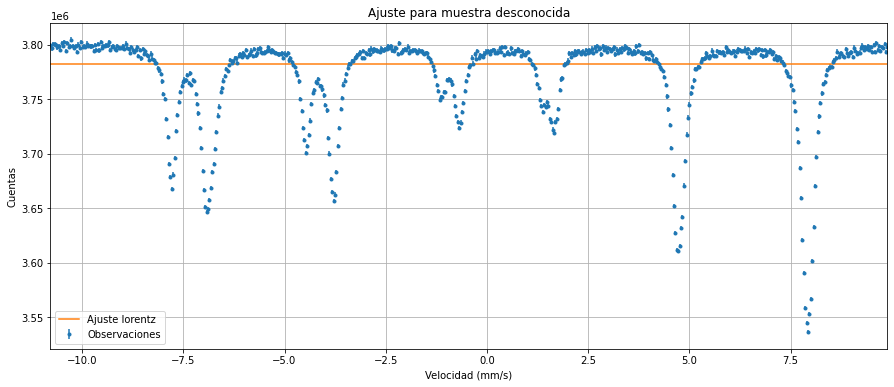

In [102]:
# el ajuste para la muestra desconocida (magnetita) con 2 sextetes

# busco los picos
threshold = 3.76e6
baseline = 3.8e6
ch_mins, count_mins, peak_counter = search_mins_alFe(canal, cuentas, threshold)
print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# agrego los picos escondidos
ch_mins = mag_hidden_peaks(ch_mins,"ch",12)
count_mins = [baseline-x for x in count_mins]
count_mins = mag_hidden_peaks(count_mins,"count",12)
peak_counter = len(ch_mins)

print("ch_mins:     ",ch_mins)
print("count_mins: ", count_mins)
print("peaks: ", peak_counter,'\n')

# los uso de parámetros iniciales
ch_mins_1 = [ch_mins[2*i] for i in range(6)]
ch_mins_2 = [ch_mins[2*i+1] for i in range(6)]

beta0_1 = [j for i in ch_mins_1 for j in [i,5]]
beta0_1.append(-2*(baseline-cuentas[ch_mins_1[2]]))

beta0_2 = [j for i in ch_mins_2 for j in [i,5]]
beta0_2.append(-2*(baseline-cuentas[ch_mins_2[2]]))

beta0 = beta0_1 + beta0_2
beta0.append(baseline)
print("parametros iniciales({}): ".format(len(beta0)),'\n', beta0,'\n')

# hago el ajuste
func = dos_sextetes
area_rates = [3,2,1,1,2,3]
fit_params, err_fit_params, chi2_red = ajustin_castor(muestra, func, area_rates, baseline, beta0, canal, err_canal, cuentas, err_cuentas)

# lo grafico pero en velocidades
h_plotter_v(muestra,func,area_rates,fit_params,err_fit_params,recta_calib(lin_fit_params,[200,800]),canal,err_canal,cuentas,err_cuentas)

[286.756221, 7.31494079, 383.202119, 7.26343337, 479.68603, 7.63888569, 552.436451, 7.7240285, 650.329992, 8.75803996, 742.748162, 9.12609535, -510195.918, 312.977841, 10.5390097, 402.808165, 8.32339315, 493.04732, 8.47844249, 560.98308, 7.93104154, 650.329992, 8.75803996, 742.748162, 9.12609535, -941276.623, 3799245.6]
27


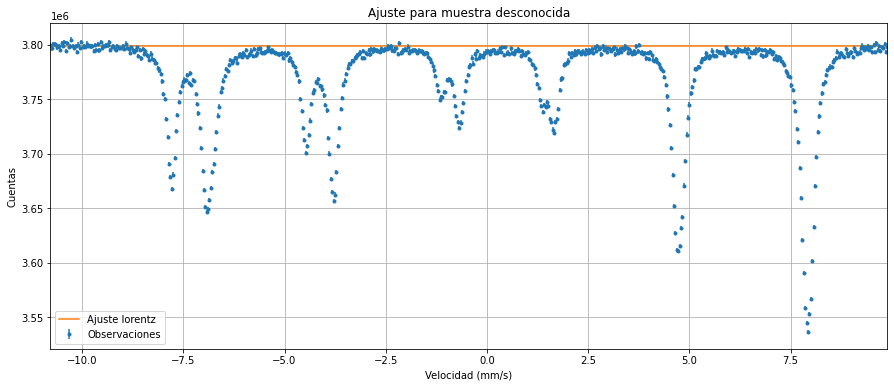

In [103]:
a = [ 2.86756221e+02,  7.31494079e+00,  3.83202119e+02,  7.26343337e+00,  4.79686030e+02,  7.63888569e+00,  5.52436451e+02,  7.72402850e+00,  6.50329992e+02,  8.75803996e+00, 7.42748162e+02,  9.12609535e+00, -5.10195918e+05]

b = [3.12977841e+02,  1.05390097e+01, 4.02808165e+02,  8.32339315e+00, 4.93047320e+02, 8.47844249e+00, 5.60983080e+02,  7.93104154e+00, 6.50329992e+02,  8.75803996e+00, 7.42748162e+02,  9.12609535e+00, -9.41276623e+05]

c = a + b
c.append(3.79924560e+06)
print(c)
print(len(c))

h_plotter_v(muestra,func,area_rates,c,err_fit_params,recta_calib(lin_fit_params,[200,800]),np.array(canal),err_canal,cuentas,err_cuentas)